In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import time

In [2]:
# Data augmentation
transformations = torchvision.transforms.Compose([
  torchvision.transforms.ColorJitter(brightness = .2, contrast = .2, saturation = .2, hue = .15),
  torchvision.transforms.RandomCrop(32, padding = 4), # add padding to borders of the image and crop randomly, output size is 32x32 (like cifar10 images)
  torchvision.transforms.RandomHorizontalFlip(p = .3),
  torchvision.transforms.RandomAffine(0, translate = (.1,.1)),
  torchvision.transforms.RandomPerspective(.3, .25),
  torchvision.transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10(".", train = True, transform = transformations, download = True)
test_ds = torchvision.datasets.CIFAR10(".", train = False, transform = transformations, download = True)

K = len(train_ds.classes)
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# define custom class

class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the convolutional layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),

        nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),

        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        
        nn.MaxPool2d(2)
    )
    # since H_out = H_in + 2p - 2. If we solve this for p, then for p=1 the result will be H_out = H_in. This means we can do "same" mode convolution 
    # if p=1

    # so the image sizes are just reducing because of pooling. Therefore:
    # 32x32 -> 16x16 -> 8x8 -> 4x4

    self.fc_dropout = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(128 * 4 * 4, 1024),
        nn.Dropout(.2),
        nn.Linear(1024, K)
    )
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1) # flatten the image
    x = self.fc_dropout(x)
    return x

In [4]:
cnn = CNN(K)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
cnn.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())

In [7]:
# define prediction and training functions
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  """
  Apply batch gradient descent to given model and data.
  Data must be DataLoader object
  """
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = time.time()
    train_loss = []
    test_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # we don't need to flatten the input since
      # we use CNN's as first layers of our NN

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # backward propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # keep the loss
      train_loss.append(loss.item())

    # calculate the loss for training too
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    # get the average loss for both train and test sets and keep them too
    avg_train_loss = np.mean(train_loss)
    avg_test_loss = np.mean(test_loss)
    train_losses[i] = avg_train_loss
    test_losses[i] = avg_test_loss

    # calculate the time
    t1 = time.time()

    print("-"*50)
    print(f"Epoch {i+1}/{epochs} took {t1-t0:.3f}s \n avg_loss for train: {avg_train_loss:.4f} \n avg_loss for test: {avg_test_loss:.4f}")
    print("-"*50)

  return train_loss, test_loss

def validation_predict(model, data_loader, acc=True):
  """
  Make predictions with given DataLoader object. 
  Return the predictions and accuracy(if acc=True) 
  """
  n_correct = 0
  n_total = 0
  predictions = np.array([])
  with torch.no_grad():
    for inputs, targets in data_loader:
      # we're getting logits from model, so applying
      # softmax would be enough

      # pass the data to gpu
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      # return the index that has maximum value of a column
      # this is almost same as applying softmax itself in our situation
      _, preds = torch.max(outputs, 1)
      if acc:
        accuracy = (preds == targets).sum().item()
        n_correct += accuracy
        n_total += (targets.shape[0])
      predictions = np.concatenate((predictions, preds.cpu().numpy()))

  return [predictions,(n_correct/n_total)] if acc else predictions

In [8]:
n_epochs = 20
train_loss, test_loss = batch_gd(cnn, criterion, optimizer, train_loader, test_loader, n_epochs)

--------------------------------------------------
Epoch 1/20 took 42.524s 
 avg_loss for train: 1.8636 
 avg_loss for test: 1.4158
--------------------------------------------------
--------------------------------------------------
Epoch 2/20 took 42.444s 
 avg_loss for train: 1.2667 
 avg_loss for test: 1.1604
--------------------------------------------------
--------------------------------------------------
Epoch 3/20 took 42.235s 
 avg_loss for train: 1.0563 
 avg_loss for test: 1.0426
--------------------------------------------------
--------------------------------------------------
Epoch 4/20 took 42.405s 
 avg_loss for train: 0.9358 
 avg_loss for test: 0.8858
--------------------------------------------------
--------------------------------------------------
Epoch 5/20 took 42.366s 
 avg_loss for train: 0.8478 
 avg_loss for test: 0.8197
--------------------------------------------------
--------------------------------------------------
Epoch 6/20 took 42.662s 
 avg_loss

In [9]:
# calculate the accuracy for train and test sets
_, train_accuracy = validation_predict(cnn, train_loader)
test_preds, test_accuracy = validation_predict(cnn, test_loader)
print(f"Train accuracy: {train_accuracy:.4f} | Test accuracy: {test_accuracy:.4f} ")

Train accuracy: 0.8439 | Test accuracy: 0.8089 


In [10]:
# now plot the losses again with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=train_loss, name='Train loss', mode = 'lines+markers'))
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=test_loss, name='Test loss', mode = 'lines+markers'))
fig.show()

In [11]:
test_preds = test_preds.astype(np.uint8)
test_inputs = test_ds.data
test_targets = np.array(test_ds.targets)
misclassified_idx = np.where(test_preds != test_targets)[0]
print(f"Total misclassified image count is {len(misclassified_idx)}")
print(f"{(len(misclassified_idx)/test_targets.shape[0]) * 100:.2f}% of the images are misclassified by the model.")

Total misclassified image count is 1911
19.11% of the images are misclassified by the model.


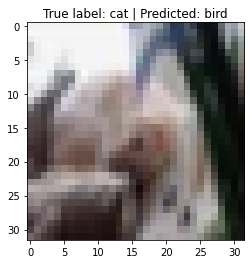

In [12]:
# plot a random example
r = np.random.choice(misclassified_idx)
plt.imshow(test_inputs[r].reshape(32,32,3), cmap = 'gray')
plt.title(f"True label: {test_ds.classes[test_targets[r]]} | Predicted: {test_ds.classes[test_preds[r]]}")
plt.show()